In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
from glob import glob
import functools
import _pickle as pickle

# display plots in this notebook
%matplotlib inline

### Set up plot attribute

In [2]:
# set display defaults
plt.rcParams['figure.figsize'] = (5, 5)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

### Import caffe package

In [3]:
# The caffe module needs to be on the Python path;
# we'll add it here explicitly.
caffe_root = '/opt/caffe'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### Create Net instance

In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + '/models/bvlc_googlenet/deploy.prototxt'
model_weights = caffe_root + '/models/bvlc_googlenet/hat_model_iter_500.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

### Set up input image transformer

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + '/python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print("mu:", mu)
print('mean-subtracted values:', zip('BGR', mu))

# create transformer for the input called 'data'
# transformer see: https://github.com/BVLC/caffe/blob/master/python/caffe/io.py
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension(变换image矩阵，把channel放到最后一维)
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255](从[0,1]rescale到[0,255])
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR(调整 channels from RGB to BGR)

mu: [ 104.00698793  116.66876762  122.67891434]
mean-subtracted values: <zip object at 0x7fc2be74aac8>


### Reshape input data

In [6]:
# set the size of the input (we can skip this if we're happy
# with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227

### Model classification 

In [11]:
FOLDER_PATH = "/workspace/caffe_image/fine_tune_image"

imgs_path = sorted(glob(FOLDER_PATH + "/img_*.jpg"))

imgs_predict = []

for idx, path in enumerate(imgs_path):
    print(idx)
    #load image see: https://github.com/BVLC/caffe/blob/master/python/caffe/io.py
    img = caffe.io.load_image(path)
    transformed_img = transformer.preprocess("data", img)    
    # copy the image data into the memory allocated for the net
    net.blobs['data'].data[...] = transformed_img
    # perform classification
    # 这里output是Net最后一层的输出向量
    output = net.forward()
    prob = output["prob"][0]
    prob = prob.tolist()
    
    imgs_predict.append(prob)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


### Dump result into pickle file

In [13]:
f = open('fine_tune_googlenet_predict.b', 'wb')
pickle.dump((imgs_path, imgs_predict), f)
f.close()

In [ ]:
with open("fine_tune_googlenet_predict.b", "rb") as f:
    imgs_path, imgs_predict = pickle.load(f)
    f.close()

### Show the pictures which are classified to hat category by model

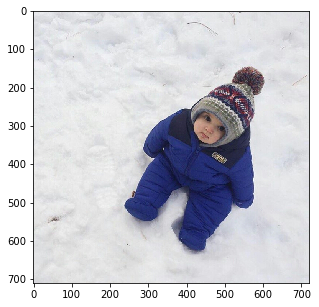

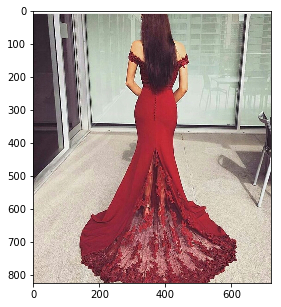

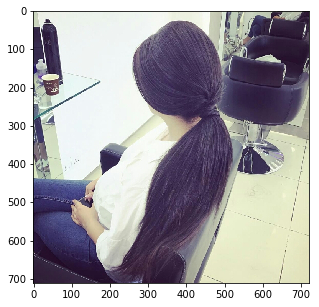

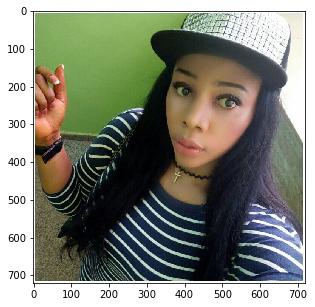

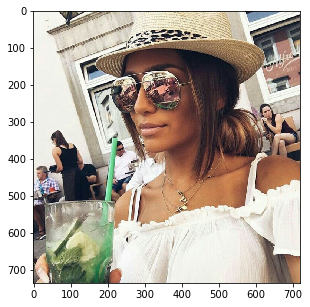

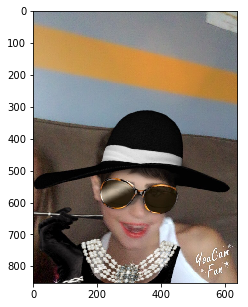

In [17]:
imgs_predict = np.array(imgs_predict)

predict_categories = list(map(lambda predict: predict.argmax(), imgs_predict))
imgs = []

for idx, cate in enumerate(predict_categories):
    if cate == 1:
        imgs.append(imgs_path[idx])
        

for path in imgs:
    img=mpimg.imread(path)
    plt.figure()
    plt.imshow(img)

In [ ]:
# Noted:
# 1.此次fine-tune僅用了500張圖片，故分類結果不是非常好

# 2.在對model進行fine-tune training與進行classification時，使用的是兩種不同的prototxt，
#   以googlenet為例，training時是用train_val.prototxt，classification時是用deploy.prototxt

# 3.fine-tune的參數調整都在solver.txt中修改

# 4.將要training的dataset包裝成LMDB，並在training時會用到的prototxt中修改data layer的source，同時也要產生對應的label.txt
#   產生label的部分可參考create_train_labels.py

# 5.build lmdb
# GLOG_logtostderr=1 $CAFFE_ROOT/build/tools/convert_imageset --resize_height=224 --resize_width=224 --shuffle /workspace/caffe_image/Googlenet_Raw_Data/ /workspace/caffe_image/train_labels/train.txt /workspace/caffe_image/train_lmdb224

# 6.start fine-tune
# $CAFFE_ROOT/build/tools/caffe train --solver $CAFFE_ROOT/models/bvlc_googlenet/solver.prototxt --weights $CAFFE_ROOT/models/bvlc_googlenet/bvlc_googlenet.caffemodel 

# 7.resume from snapshot
# $CAFFE_ROOT/build/tools/caffe train --solver $CAFFE_ROOT/models/bvlc_googlenet/solver.prototxt --snapshot $CAFFE_ROOT/models/bvlc_googlenet/hat_model_iter_400.solverstate


In [ ]:
# 1.A step by step guide to Caffe: http://shengshuyang.github.io/A-step-by-step-guide-to-Caffe.html
# 2.Fine Tuning of GoogLeNet Model: https://stackoverflow.com/questions/36841158/fine-tuning-of-googlenet-model
# 3.Caffe fine-tuning 微调网络: http://www.cnblogs.com/louyihang-loves-baiyan/p/5038758.html